In [151]:
#from ler.gw_source_population import merger_rate_density_bbh_popI_II_oguri2018
import numpy as np
import matplotlib.pyplot as plt
# interpolate
from scipy.interpolate import interp1d
from scipy.integrate import trapz, simps, quad
from gwsnr import GWSNR
from ler.rates import LeR
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

In [152]:
# zs to dl
zs_arr = np.geomspace(0.0001, 5, 10000)
dl_arr = cosmo.luminosity_distance(zs_arr).value
zs_to_dl = interp1d(zs_arr, dl_arr, kind='cubic')
dl_to_zs = interp1d(dl_arr, zs_arr, kind='cubic')

## Horizon distance

In [22]:
snr = GWSNR(gwsnr_verbose=False, ifos=['L1'])

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle


In [23]:
snr.detector_horizon(mass_1=1.4, mass_2=1.4)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]

dl_eff 123.76356521495073
optimal_snr_unscaled [26.92197778]


{'L1': array([416.49499405]), 'net': array([416.49499405])}

## Merger rate density

In [160]:
def merger_rate_density_bbh_popI_II_oguri2018(
        zs, R0=105.5 * 1e-9, b2=1.6, b3=2.0, b4=30,
    ):
    """
    Function to compute the merger rate density (PopI/PopII). Reference: Oguri et al. (2018). The output is in detector frame and is unnormalized.

    Parameters
    ----------
    zs : `float` or `numpy.ndarray` (nD array of floats)
        Source redshifts
    R0 : `float`
        local merger rate density at low redshift
        default: 105.5*1e-9 Mpc^-3 yr^-1
    b2 : `float`
        Fitting paramters
        default: 1.6
    b3 : `float`
        Fitting paramters
        default: 2.0
    b4 : `float`
        Fitting paramters
        default: 30

    Returns
    ----------
    rate_density : `float` or `numpy.ndarray` (nD array of floats)
        merger rate density

    Examples
    ----------
    >>> from ler.gw_source_population import merger_rate_density_bbh_popI_II_oguri2018
    >>> rate_density = merger_rate_density_bbh_popI_II_oguri2018(zs=0.1)
    """
    
    # rate_density
    return R0 * (b4 + 1) * np.exp(b2 * zs) / (b4 + np.exp(b3 * zs))

In [209]:
def snr_operator(zs):

    zhor = dl_to_zs(416.49499405)
    result = np.zeros_like(zs)
    result[zs < zhor] = 1

    return result


## Unlensed Rate

\begin{equation}
\begin{aligned}
\mathcal{R}^U = \int_{0}^{z_{\text{max}}} \frac{R(z_s)}{1+z_s}\frac{dV_c}{dz_s} \Theta(z_{\text{hor}}-z_s) dz_s
\end{aligned}
\end{equation}

Or,

\begin{equation}
\begin{aligned}
\mathcal{R}^U = \int_{0}^{z_{\text{hor}}} \frac{R(z_s)}{1+z_s}\frac{dV_c}{dz_s} dz_s
\end{aligned}
\end{equation}

### Integration with `quad` function

In [162]:
# intergrand function
def unlensed_integrand(zs):

    merger_rate = merger_rate_density_bbh_popI_II_oguri2018(zs=zs)
    dvc_dz = cosmo.differential_comoving_volume(zs).value * 4 * np.pi
    snr_op = snr_operator(zs=zs)
    
    return merger_rate/(1+zs) * dvc_dz * snr_op

In [163]:
# integral
integral_unlensed = quad(unlensed_integrand, 0, 5)[0]

In [164]:
integral_unlensed

25.548761224160824

### Integration with `np.trapz` function

In [237]:
# intergrand function
def unlensed_integrand(zs):

    merger_rate = merger_rate_density_bbh_popI_II_oguri2018(zs=zs)
    dvc_dz = cosmo.differential_comoving_volume(zs).value * 4 * np.pi
    tau = optical_depth_SIS_haris(zs)
    
    result = merger_rate/(1+zs) * dvc_dz * snr_operator(zs)

    return result 

In [238]:
zs = np.geomspace(0.0001, 5, 100000)
unlensed_integrand_arr = np.array([unlensed_integrand(z) for z in zs])
integral_unlensed = np.trapz(unlensed_integrand_arr, zs)

In [239]:
integral_unlensed

25.54619777504021

## Lensed rate

\begin{equation}
\begin{aligned}
\mathcal{R}^L = \int_{0}^{z_{\text{max}}} \frac{R(z_s)}{1+z_s}\frac{dV_c}{dz_s} \Theta(z_{\text{hor}}-z_s) \tau(z_s) P(\mu) dz_s
\end{aligned}
\end{equation}

- $P(\mu) = 8 \mu^{-3}$



In [175]:
# redshift to comoving distance
cosmo.comoving_distance(0.1)

<Quantity 418.45448763 Mpc>

In [176]:
def optical_depth_SIS_haris(zs):
    """
    Function to compute the strong lensing optical depth (SIS). \n
    LambdaCDM(H0=70, Om0=0.3, Ode0=0.7) was used to derive the following equation. This is the analytic version of optical depth from z=0 to z=zs.

    Parameters
    ----------
    zs : `float`
        source redshifts

    Returns
    -------
    tau : `float`
        strong lensing optical depth
    """

    # z to luminosity_distance (luminosity_distance) conversion
    Dc = cosmo.comoving_distance(zs).value * 1e-3  # 1e-3 converts Mpc to Gpc

    return (Dc / 62.2) ** 3  # 62.2 is the critical density in Gpc

In [305]:
def magnification_function(mu):
    """
    Function to compute the magnification function. \n
    This is the analytic version of the magnification function.

    Parameters
    ----------
    mu : `float`
        magnification

    Returns
    -------
    P : `float`
        magnification function
    """

    return 8 / mu**3

In [285]:
cosmo.luminosity_distance(0.1)

<Quantity 460.29993639 Mpc>

In [286]:
def snr_operator_lensed(zs, mu):

    zhor = 416.49499405
    # redshift to luminosity_distance conversion
    dl = cosmo.luminosity_distance(zs).value # Mpc
    dl_eff = dl / np.sqrt(mu) # effective luminosity distance
    result = np.zeros_like(dl_eff)
    result[dl_eff < 416.49499405] = 1
    return result

In [287]:
# intergrand function
# def lensed_integrand(zs):

#     merger_rate = merger_rate_density_bbh_popI_II_oguri2018(zs=zs)
#     dvc_dz = cosmo.differential_comoving_volume(zs).value * 4 * np.pi
#     tau = optical_depth_SIS_haris(zs)

#     # integration over only mu dependent part
#     integrand_fn = lambda mu:  snr_operator_lensed(zs=zs, mu=mu)  * magnification_function(mu)
    
#     result = quad(integrand_fn, 2, 1e4)[0]

#     return result * merger_rate/(1+zs) * dvc_dz* tau

In [288]:
# intergrand function
def lensed_integrand(zs):

    merger_rate = merger_rate_density_bbh_popI_II_oguri2018(zs=zs)
    dvc_dz = cosmo.differential_comoving_volume(zs).value * 4 * np.pi
    tau = optical_depth_SIS_haris(zs)

    # integration over only mu dependent part
    integrand_fn = lambda mu:  merger_rate/(1+zs) * dvc_dz* tau * snr_operator_lensed(zs=zs, mu=mu)  * magnification_function(mu)

    mu = np.geomspace(2, 1e4, 1000)

    integrand_arr = integrand_fn(mu)
    
    result = np.trapz(integrand_arr, x=mu)

    return result 

In [289]:
# integral
zs = np.geomspace(0.0001, 5, 10000)
lensed_integrand_arr = []
for z in zs:
    lensed_integrand_arr.append(lensed_integrand(z))
lensed_integrand_arr = np.array(lensed_integrand_arr)
integral_lensed = np.trapz(lensed_integrand_arr, zs)

In [290]:
integral_lensed

0.0014014771187002028

In [291]:
integral_unlensed/integral_lensed

18192.51990092766

## Unlensed monte-carlo integration

\begin{equation}
\begin{aligned}
\mathcal{R}^U = N \Big<\Theta(z_{\text{hor}}-z_s)\Big>_{z_s\in P(z_s)} 
\end{aligned}
\end{equation}

- $P(z_s) = \frac{1}{N} \frac{R(z_s)}{1+z_s} \frac{dV_c}{dz_s}$

- $N=\int \frac{R(z_s)}{1+z_s} \frac{dV_c}{dz_s} dz_s$

In [327]:
# find normalization factor
zs = np.geomspace(0.0001, 0.2, 10000)
buffer_fn = lambda zs: merger_rate_density_bbh_popI_II_oguri2018(zs=zs)/(1+zs) * cosmo.differential_comoving_volume(zs).value * 4 * np.pi

buffer_arr = np.array([buffer_fn(z) for z in zs])
norm_unlensed = np.trapz(buffer_arr, zs)

In [328]:
def pdf(zs):
    return buffer_fn(zs) / norm_unlensed

In [329]:
def rejection_sample(pdf, xmin, xmax, size=100, chunk_size=10000):
    """
    Helper function for rejection sampling from a pdf with maximum and minimum arguments.
    
    Parameters
    ----------
    pdf : `function`
        pdf function.
    xmin : `float`
        minimum value of the pdf.
    xmax : `float`
        maximum value of the pdf.
    size : `int`, optional
        number of samples. Default is 100.
    chunk_size : `int`, optional
        chunk size for sampling. Default is 10000.

    Returns
    ----------
    x_sample : `numpy.ndarray`
        samples from the pdf.
    """
    x = np.linspace(xmin, xmax, chunk_size)
    y = pdf(x)
    # Maximum value of the pdf
    ymax = np.max(y)

    # Rejection sample in chunks
    x_sample = []
    while len(x_sample) < size:
        x_try = np.random.uniform(xmin, xmax, size=chunk_size)
        pdf_x_try = pdf(x_try) # Calculate the pdf at the random x values
        # this is for comparing with the pdf value at x_try, will be used to accept or reject the sample
        y_try = np.random.uniform(0, ymax, size=chunk_size)
        
        # Update the maximum value of the pdf
        ymax = max(ymax, np.max(pdf_x_try))  
        
        # applying condition to accept the sample
        # Add while retaining 1D shape of the list
        x_sample += list(x_try[y_try < pdf_x_try])

    # Transform the samples to a 1D numpy array
    x_sample = np.array(x_sample).flatten()
    # Return the correct number of samples
    return x_sample[:size]

In [330]:
zs_sample = rejection_sample(pdf, 0.0001, 0.2, size=1000000)

In [331]:
np.sum(zs_sample<0.1)

128736

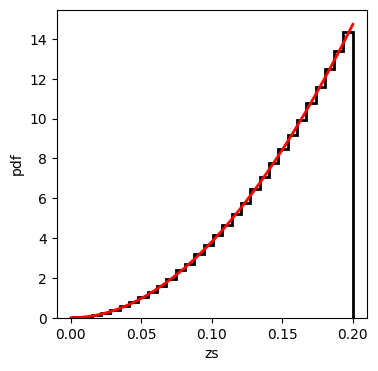

In [332]:
plt.figure( figsize=(4,4))
plt.hist(zs_sample, bins=30, histtype='step', color='k', lw=2, density=True)
plt.plot(zs, pdf(zs), color='r', lw=2)
plt.xlabel('zs')
plt.ylabel('pdf')
plt.show()

In [333]:
integral_unlensed = norm_unlensed* np.mean(snr_operator(zs_sample))
integral_unlensed

25.612433029679842

## Lensed monte-carlo integration

\begin{equation}
\begin{aligned}
\mathcal{R}^L = N^L \Big<\Theta(z_{\text{hor}}(\mu)-z_s)\Big>_{z_s\in P(z_s|SL), \mu \in P(\mu)} 
\end{aligned}
\end{equation}

- $P(z_s) = \frac{1}{N^L} \tau(z_s) \frac{R(z_s)}{1+z_s} \frac{dV_c}{dz_s}$

- $P(\mu) = 8 \mu^{-3}$

- $N=\int \tau(z_s) \frac{R(z_s)}{1+z_s} \frac{dV_c}{dz_s} dz_s$

In [306]:
# find normalization factor
zs = np.geomspace(0.0001, 10, 10000)
buffer_fn_lensed = lambda zs: optical_depth_SIS_haris(zs)* merger_rate_density_bbh_popI_II_oguri2018(zs=zs)/(1+zs) * cosmo.differential_comoving_volume(zs).value * 4 * np.pi

buffer_arr = np.array([buffer_fn_lensed(z) for z in zs])
norm_lensed = np.trapz(buffer_arr, zs)

In [307]:
def pdf_lensed(zs):
    return buffer_fn_lensed(zs) / norm_lensed

In [321]:
zs_sample = rejection_sample(pdf_lensed, 0.0001, 10, size=10000)
mu_sample = rejection_sample(magnification_function, 2, 1e4, size=100000)

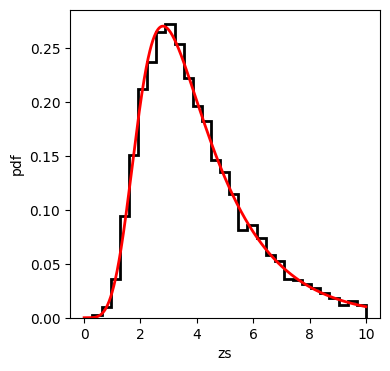

In [322]:
plt.figure( figsize=(4,4))
plt.hist(zs_sample, bins=30, histtype='step', color='k', lw=2, density=True)
plt.plot(zs, pdf_lensed(zs), color='r', lw=2)
plt.xlabel('zs')
plt.ylabel('pdf')
plt.show()

In [323]:
# from numba import njit

# @njit
def integrad_lensed(zs):
    len_ = len(zs)
    result = np.zeros(len_)
    for i, z in enumerate(zs):
        result[i] = np.mean(snr_operator_lensed(z*np.ones_like(mu_sample), mu_sample))
    return result

In [324]:
integrad_lensed(np.array([0.1,0.2]))

array([1.     , 0.13109])

In [325]:
integral_lensed = norm_lensed* np.mean(integrad_lensed(zs_sample))
integral_lensed

0.0026864627184197323

In [335]:
integral_unlensed, integral_lensed, integral_unlensed/integral_lensed

(25.612433029679842, 0.0026864627184197323, 9533.887388076591)

## LeR result and analytical result

| $R_o (Gpc^{-1}yr^{-1})$ | Unlensed | Lensed | ratio | $z_{max}$ (unlensed, lensed) | method | 
| --- | --- | --- | --- | --- | --- |
| 105.5 | 12.678 | 0.0306 | 414.31 | 0.2, 10 | ler |
| 105.5 | 25.546 | 0.0014 | 18247.14 | 0.2, 10 | trapz |
| 105.5 | 25.61 | 0.00268 | 9555.97 | 0.2, 10 | montecarlo |

In [339]:
25.61/0.00268

9555.970149253732